In [7]:
import numpy as np 
import torch
import matplotlib.pyplot as plt 
import gymnasium as gym
import torch.nn.functional as F
import copy
from stable_baselines3 import PPO,SAC
from Models import Models_env
from casadi import *  
#Global params
T = 26
nsteps = 100


In [182]:
SP = {
    'Ca': [0.8 for i in range(int(nsteps/2))] + [0.9 for i in range(int(nsteps/2))],
}

#Continuous box action space
action_space = {
    'low': np.array([295]),
    'high':np.array([302]) 
}
#Continuous box observation space
observation_space = {
    'low' : np.array([0.7,300,0.8]),
    'high' : np.array([1,350,0.9])  
}

r_scale ={
    'Ca': 5 #Reward scale for each state
}
disturbance = {
    'Caf': np.array([1 for i in range(int(nsteps/4))]+[1.05 for i in range(int(nsteps/2))]+[1 for i in range(int(nsteps/4))]),
}
env_params = {
    'Nx': 2, # Number of states
    'N': nsteps, # Number of time steps
    'tsim':T, # Simulation Time
    'Nu':1, # Number of control/actions
    'SP':SP, #Setpoint
    'o_space' : observation_space, #Observation space
    'a_space' : action_space, # Action space
    'dt': 1., # Time step
    'x0': np.array([0.8,324.9,0.8]), # Initial conditions (torch.tensor)
    'model': 'cstr_ode', #Select the model
    'r_scale': r_scale, #Scale the L1 norm used for reward (|x-x_sp|*r_scale)
    'normalise_a': True, #Normalise the actions
    'normalise_o':True, #Normalise the states,
    'noise':True, #Add noise to the states
    'integration_method': 'casadi', #Select the integration method
    'noise_percentage':0.001, #Noise percentage
    
}


cons = {
    'T' :325
}

cons_type = {
    'T':'<='
}

env_params.update({
'done_on_cons_vio':False,
'constraints': cons, 
'cons_type': cons_type,
'r_penalty': True})
env = Models_env(env_params)

Oracle Class

In [193]:
class oracle():
    '''
    Oracle Class - Class to solve the optimal control problem with perfect 
    knowledge of the environment.

    Inputs: Env

    Outputs: Optimal control and state trajectories
    '''

    def __init__(self,env,env_params):  
      self.env = env(env_params)
      self.env_params = env_params
      self.T = 1
      self.N = 10
      self.model_info = self.env.model.info()
    def model_gen(self):
      '''
      Generates a model for the given environment.

      Returns:
      f: A casadi function that can be used to solve the differential equations defined by the model.
      '''
      self.u  = MX.sym('u',self.env.Nu)
      
      self.x = MX.sym('x',self.env.Nx)
      dxdt = self.env.model(self.x,self.u)
      dxdt = vertcat(*dxdt)
      f = Function('f',[self.x,self.u],[dxdt],['x','u'],['dxdt'])
      return f
    
    def integrator_gen(self):
      '''
      Generates an integrator object for the given model.

      Returns:
      F: A casadi function that can be used to integrate the model over a given time horizon.
      '''
      f = self.model_gen()
      intg_options = {'tf': self.T/self.N, 'simplify': True, 'number_of_finite_elements': 4} #TODO: Make T and N customisable
      dae = {'x': self.x, 'p': self.u, 'ode': f(self.x, self.u)}
      intg = integrator('intg', 'rk', dae, intg_options)
      res = intg(x0=self.x, p=self.u)
      x_next = res['xf']
      F = Function('F',[self.x,self.u],[x_next],['x','u'],['x_next'])
      return F
    def disturbance_index(self):
      
      '''
      Generates the indices of when the disturbance value changes.
      
      Inputs: self

      Returns: index of when the disturbance value changes.
      
      '''
      index = []
      if self.env_params.get('disturbances') is not None:
        for key in self.env_params['disturbances']:
          disturbance = self.env_params['disturbances'][key]
          for i in range(disturbance.shape[0]-1):
            if disturbance[i] != disturbance[i+1]:
              index.append(i+1)
      for key in self.env_params['SP']:
        SP = self.env_params['SP'][key]
        for i in range(len(SP)-1):
          if SP[i] != SP[i+1]:
            index.append(i+1)
      
      index = list(set(index))
      return index
       
    def ocp(self,t_step):
      """
      Solves an optimal control problem (OCP) using the IPOPT solver.

      Returns:
      - M: A function that takes current state x_0 (p) and returns the optimal control input u.

      """
      opti = Opti()
      F = self.integrator_gen()
      x = opti.variable(self.env.Nx, self.N+1)
      # Define the control variable
 
      u = opti.variable(self.env.Nu, self.N)
           
      p = opti.parameter(self.env.Nx, 1)
     
      
      setpoint = opti.parameter(len(self.env_params['SP']), self.N+1)
      cost = 0
      for k in self.env_params['SP']:
        i  = self.model_info['states'].index(k)  
        cost += sum1(sum2((x[i,:] - setpoint[i,:])**2))*self.env_params['r_scale'][k] #TODO: Remember to change this when custom rewards are implemented
      

      opti.minimize(cost)

      for k in range(self.N):
        opti.subject_to(x[:, k+1] == F(x[:, k], u[:, k]))

      opti.subject_to(u[0,:] >= self.env_params['a_space']['low'])
      opti.subject_to(u[0,:] <= self.env_params['a_space']['high'])
      
      if self.env_params.get('disturbances') is not None:
        for i, k in enumerate(self.env.model.info()['disturbances'], start=0):
          if k in self.env.disturbances.keys():
            opti.subject_to(u[self.env.Nu-len(self.env.model.info()['disturbances'])+i,:] == self.env.disturbances[k][t_step]) # Add disturbance to control vector
            opti.set_initial(u[self.env.Nu-len(self.env.model.info()['disturbances'])+i,:], self.env.disturbances[k][t_step])
          else:
            opti.subject_to(u[self.env.Nu-len(self.env.model.info()['disturbances'])+i,:] == self.model_info['parameters'][str(k)]) # if there is no disturbance at this timestep, use the default value
            opti.set_initial(u[self.env.Nu-len(self.env.model.info()['disturbances'])+i,:], self.model_info['parameters'][str(k)])
       
      opti.subject_to(x[:, 0] == p )
      if self.env_params.get('constraints') is not None:
        for k in self.env_params['constraints']:
          if self.env_params['cons_type'][k] == '<=':
            opti.subject_to(x[self.model_info['states'].index(k),:] <= self.env_params['constraints'][k])
          elif self.env_params['cons_type'][k] == '>=':
            opti.subject_to(x[self.model_info['states'].index(k),:] >= self.env_params['constraints'][k])
          else:
            raise ValueError('Invalid constraint type')
      
      opti.solver('ipopt')
      SP_i = np.fromiter({k: v[t_step] for k, v in self.env_params['SP'].items()}.values(),dtype=float)
      
     
      setpoint_value = SP_i*np.ones((self.N+1,1))
      
      opti.set_value(setpoint, setpoint_value.T)
      opti.set_value(p, self.env_params['x0'][:self.env.Nx])
      initial_x_values = np.zeros((self.env.Nx, self.N+1))
      initial_x_values = (self.env_params['x0'][:self.env.Nx]*np.ones((self.N+1,self.env.Nx))).T  

      opti.set_initial(x, initial_x_values)

     
     
      opti.set_initial(u[0,:], self.env_params['a_space']['low']) 
     

      opts = {
        'ipopt': {
          'print_level': 0,
        },
        'print_time': 0
      }

    
      opti.solver('ipopt', opts)
      M = opti.to_function('M', [p], [u[:,1]], ['p'], ['u'])
      return M
    
    def mpc(self):
      '''
      Solves a model predictive control problem (MPC) using the optimal control problem (OCP) solver.

      Returns:
      - x_opt: Optimal state trajectory
      - u_opt: Optimal control trajectory
      '''
      regen_index = self.disturbance_index()
      
      M = self.ocp(t_step=0)
      F = self.integrator_gen()
      self.ts = 100
      u_log = np.zeros((self.env.Nu,self.ts))
      x_log = np.zeros((self.env.Nx,self.ts))
      x = np.array(self.env_params['x0'][:self.env.Nx])
      for i in range(self.ts):
         
          if i in regen_index:
            M = self.ocp(t_step=i)          
          try:
              x_log[:,i] = x
          except:
              x_log[:,i] = x.reshape(-1)
          if self.env_params['noise'] is True:
            noise_percentage = self.env_params['noise_percentage']
            try:
              x += np.random.normal(0,1,(self.env.Nx)) * x * noise_percentage
            except:
              x += np.random.normal(0,1,(self.env.Nx,1)) * x * noise_percentage
          u = M(x).full()
          u_log[:,i] = u[0]
          x = F(x,u).full() 
      return x_log, u_log


In [132]:
env_params['a_space']['low']

array([295])

In [195]:
o = oracle(Models_env,env_params)
x_star, u_star = o.mpc()

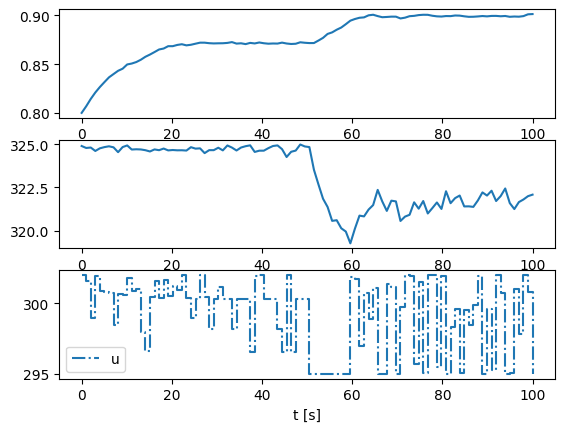

In [196]:
# Create a time grid for plotting
tgrid = np.linspace(0, o.ts, o.ts)

# Create a new figure
plt.figure()


# Plot x1 and x2
plt.subplot(3, 1, 1)
plt.plot(tgrid, x_star[0, :], label='x1')
plt.subplot(3, 1, 2)
plt.plot(tgrid, x_star[1, :], label='x2')

# Plot u with stairs and add a NaN at the end

plt.subplot(3, 1, 3)
plt.step(tgrid, u_star[0,:], '-.', where='post', label='u')

# Add labels and legend
plt.xlabel('t [s]')
plt.legend()

# Show the plot
plt.show()